In [1]:
import pandas as pd
import numpy as np
import warnings
import os, sys
import pickle

warnings.filterwarnings("ignore")

In [2]:
df=pd.read_csv('../Data/Spotify_with_genre.csv')
df.head()

,artist_name,track_name,artist_pop,popularity,release_date,genre,track_uri,artist_uri
0,A Thousand Horses,Preachin' To The Choir,37.0,0.0,2017-06-02,Rap,6JKj9seJCshLVCfBLFp7dS,55RI2GNCfyXr0f14uIdhwd
1,Water Liars,You Work Days I Work Nights,29.0,10.0,2012,dnb,7L7u4PrNt5WMtVI9lHWlLm,6k3UpifDbb2ox25edM5j3P
2,Chambao,Sera,44.0,31.0,2007-11-06,Rap,12EyOqMPMyAKlKSynICAGN,2qhLqZ1pkiUl5HNrU2Nz0R
3,Jeezy,Big Shit Poppin,69.0,19.0,2007-08-07,Rap,3tCDjKseLQJhShfbeg4m7K,4yBK75WVCQXej1p04GWqxH
4,La Arrolladora Banda El Limón De Rene Camacho,No La Voy A Engañar,74.0,54.0,2012,Rap,0UICwSsSpUt98XkeCfupFn,5bSfBBCxY8QAk4Pifveisz


In [3]:
base_path='../Models/'

In [4]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
df['artist_name'] = label_encoder.fit_transform(df['artist_name'])

with open(base_path+'label_encoder.pkl', 'wb') as f:
    pickle.dump(label_encoder, f)


In [5]:

with open(base_path+'encoder.pkl', 'rb') as f:
    genre_encoder = pickle .load(f)
    
df['genre'] = genre_encoder.transform(df['genre'])

In [6]:
df['release_date']=pd.to_datetime(df['release_date'], errors='coerce')
df.dropna(subset=['release_date'], inplace=True)
df['year'] = df['release_date'].dt.year
df.drop(columns=['release_date'], inplace=True)

In [7]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
numerical_features = ['artist_pop', 'popularity']
df[numerical_features] = scaler.fit_transform(df[numerical_features])

In [8]:
features_for_clustering = ['artist_pop', 'popularity', 'year', 'genre', 'artist_name']
weights= {'artist_pop': 1, 'popularity': 1, 'year': 1, 'genre': 1, 'artist_name': 1}

In [9]:
df['artist_pop'] = df['artist_pop']*weights['artist_pop']
df['popularity'] = df['popularity']*weights['popularity']
df['year'] = df['year']*weights['year']



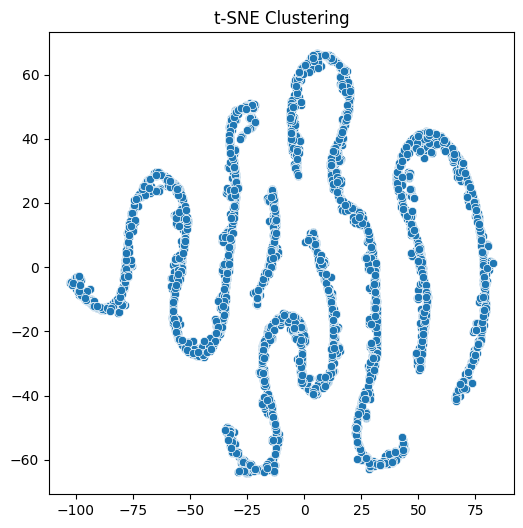

In [10]:


from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

# initialize the tsne model
tsne = TSNE(n_components=2, random_state=0)
# perform the tsne
tsne_obj = tsne.fit_transform(df[features_for_clustering])

plt.figure(figsize=(6, 6))
sns.scatterplot(x=tsne_obj[:, 0], y=tsne_obj[:, 1])
plt.title('t-SNE Clustering')
plt.show()

In [11]:
from sklearn.cluster import Birch

# initialize the BIRCH model
birch = Birch(n_clusters=7)

# fit the model to the data
birch.fit(df[features_for_clustering])

# predict the clusters
df['cluster'] = birch.predict(df[features_for_clustering])

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

def plotClusters(col,algoName):
    for idx,i in enumerate(features_for_clustering):
        for j in features_for_clustering[idx+1:]:
            if i==j:
                continue
            plt.figure(figsize=(6,4))
            sns.scatterplot(data=df,x=i,y=j,hue=col,palette='viridis')
            plt.title(f'{algoName} Clusters')
            plt.show() 

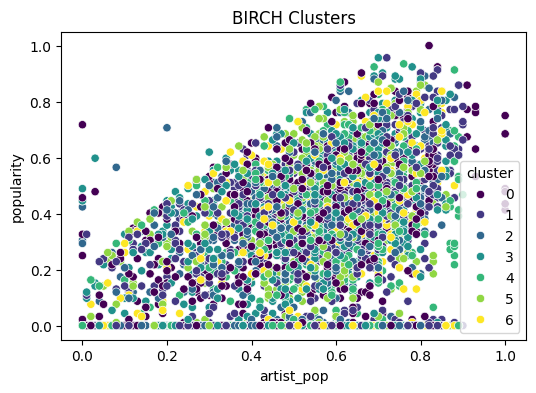

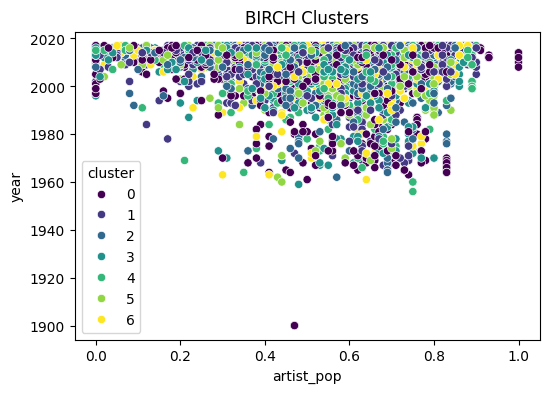

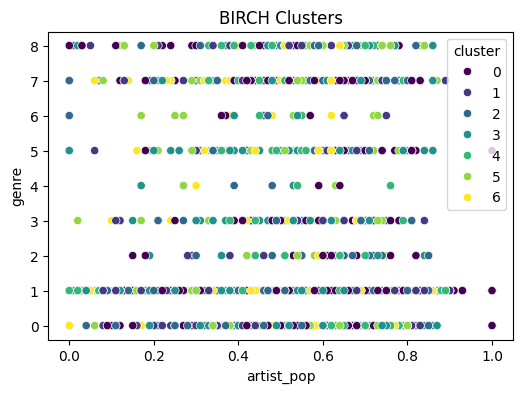

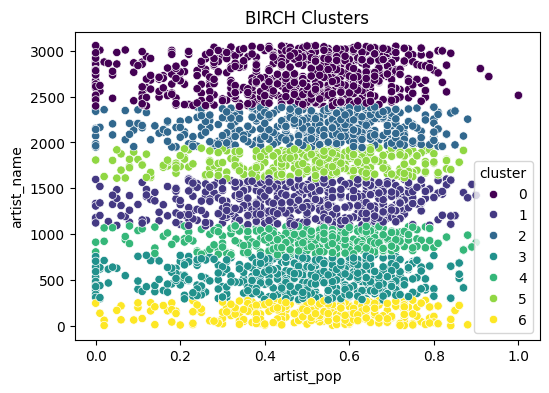

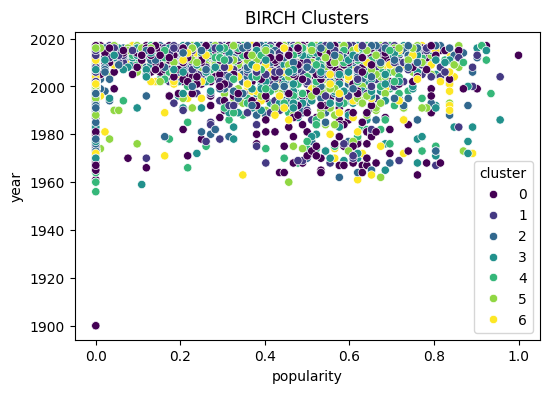

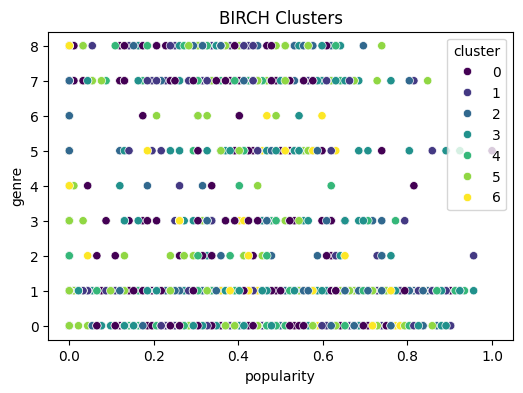

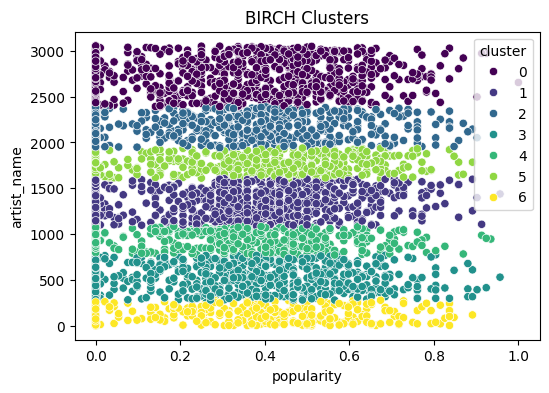

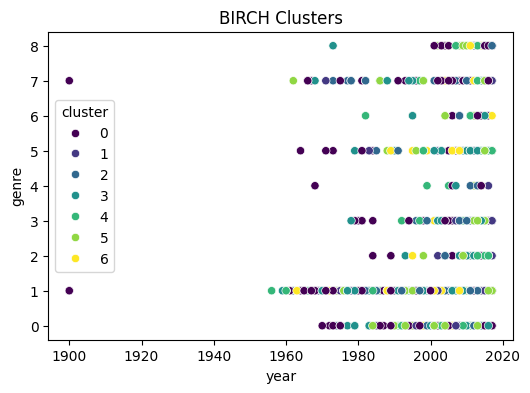

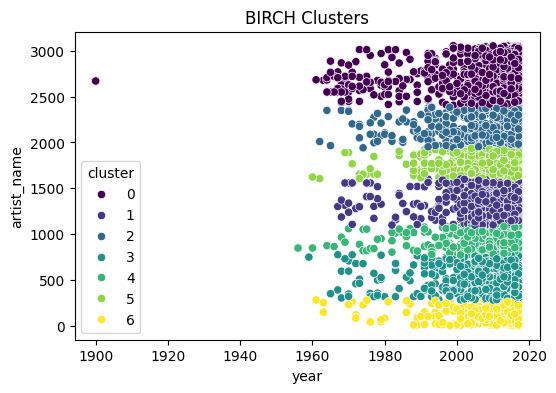

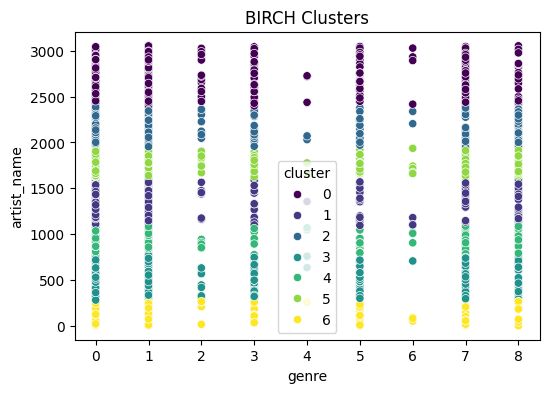

In [13]:
plotClusters('cluster','BIRCH')

In [14]:
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

print(f'Silhouette Score: {silhouette_score(df[features_for_clustering], df["cluster"])}')
print(f'Calinski Harabasz Score: {calinski_harabasz_score(df[features_for_clustering], df["cluster"])}')
print(f'Davies Bouldin Score: {davies_bouldin_score(df[features_for_clustering], df["cluster"])}')

Silhouette Score: 0.5049340870408414
Calinski Harabasz Score: 31407.346523946504
Davies Bouldin Score: 0.5125214328644712


In [15]:
df.to_csv('../Data/Spotify_with_genre_clustered.csv', index=False)

In [16]:
with open(base_path+'birch.pkl', 'wb') as f:
    pickle.dump(birch, f)